In [5]:
import math
import numpy as np
rng = np.random.default_rng(2025)


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='Open Sans'

In [6]:
def plot_series(seriess):

    n_series = len(seriess)
    colors = plt.colormaps['coolwarm'](np.linspace(0,1,n_series))

    fig, ax = plt.subplots(1,1,figsize=(4,2), dpi=200)

    for color, series in zip(colors, seriess):
        ax.plot(series, c=color, linewidth=0.5, alpha=0.2)

    ax.set_xlabel('Time [steps]')
    ax.set_ylabel('Amount [units]')

In [73]:
@dataclass
class IExperiment:
    species: np.ndarray
    reaction_constants: np.ndarray
    rng: np.random._generator.Generator

    @abstractmethod
    def _compute_propensities(self, dt) -> np.ndarray:
        pass

    @abstractmethod
    def _apply_reaction(self, reaction_index: int):
        pass

    def step_reaction(self, dt) -> np.ndarray:

        propensities = self._compute_propensities(dt)

        # When reaction happens
        alpha_0 = propensities.sum()
        time_to_reaction = rng.exponential(1/alpha_0)

        # Which reaction happens
        reaction_index = rng.multinomial(1, propensities/alpha_0).argmax()

        self._apply_reaction(reaction_index)

        return self.species.copy(), time_to_reaction



Consider the reaction 

$$
A \longrightarrow \empty
$$

happening at some rate $k$.



**Naive SSA**

We fix $\Delta t$, and a starting number of molecules $A(0)$ and consider the following algoritm
1. Extract $r \sim U(0,1)$
2. If $r < A(t) k \Delta t$, single molecule decayed (multiple decays are order $\Delta t^n$) we sutract $1$ from $A$. Otherwise we leave it as it is. 

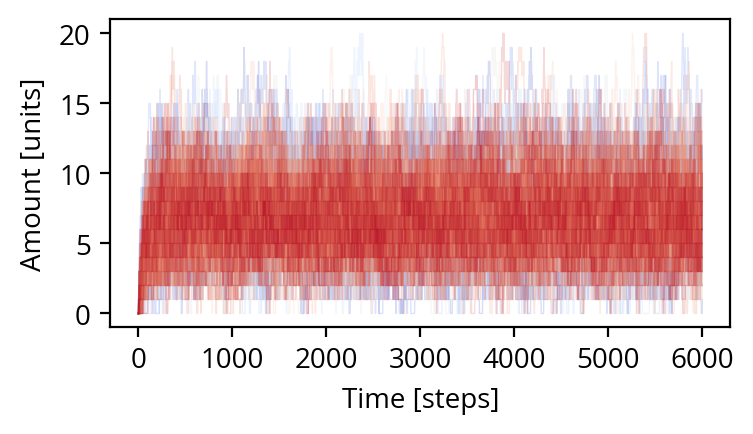

In [7]:
delta_t = 5e-3
n_steps = 6000
n_trials = 200

# k_dec = rng.normal(size=n_trials)+1
k_dec = rng.normal(size=n_trials)*0.1 + 3
k_prod = rng.normal(size=n_trials)*3 + 20
A_0 = 0

A = [np.ones(n_trials)*A_0]
# Extract the rs all together so we can spare some time
rs_dec = rng.uniform(0,1,(n_steps, n_trials))
rs_prod = rng.uniform(0,1,(n_steps, n_trials))

for rd, rp in zip(rs_dec, rs_prod):
    decayed_indexes = np.where(rd < A[-1] * k_dec * delta_t)
    produced_indexes = np.where(rp < k_prod * delta_t)
    
    new_A = A[-1].copy()
    new_A[decayed_indexes] -= 1
    new_A[produced_indexes] += 1
    A.append(new_A)

A = np.stack(A)
plot_series(A.T)

**Gillesipe approach (waiting times)**

Instead of throwing a dice every step, we throw one dice for every reaction, because we suppose that most of the timesteps nothing happens.
So, for each time interval $ds$ the probability of a reaction happening is $A(t) k ds$ (first order approximation still counts).
The probability of nothing happening for a discrete interval $t, t+s$ can be computed with a trick (that is good to have clear as it probably pops out often).

We do not focus on the AMOUNT (this is the master equation approach, I would say), but on the probability of reacions occurring at some time.
Remember, the proabability of one decay occurring at one interval dt is $A(t) k dt$.
The probability of no raction occurring $t+s$ and $t+s+ds$ is $g(t+s+ds | A(t))$
This equation has the recursive property

$$
g(t+s+ds| A(t),t) = g(t+s | A(t),t) g(t+s+ds|A(t),t+s) = g(t+s|A(t),t) [1 - A(t) k ds]
$$

then by approximating to the first order, we get

$$
g'(t+s| A(t),t) = -g(t+s| A(t), t) A(t) k
$$

**It is this equation that tells us that the waiting time s is distributed exponentially.**
So we sample this exponential $s$ and say that in $t+s$ our species has lost one unit.

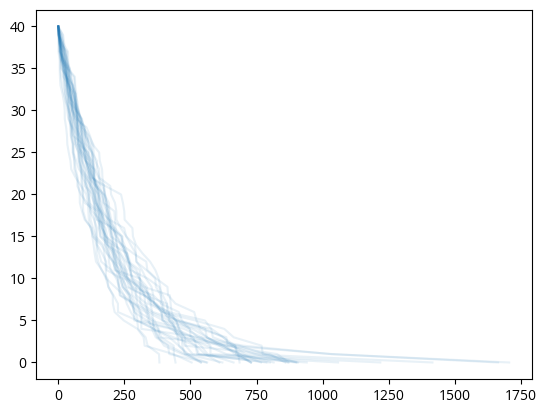

In [8]:
delta_t = 5e-3
n_steps = 6000
n_trials = 30

k = 1


for _ in range(n_trials):
    As = [40,]
    ts = [0,]
    
    while (ts[-1] < n_steps) and (As[-1]>0):
        t = rng.exponential(scale=1/(delta_t * As[-1]))
        As.append(As[-1]-1)
        ts.append(ts[-1]+t)

    plt.plot(ts, As, c='tab:blue', alpha=0.1)


**Two reactions together**

We now focus on $\emptyset \to A$ and $A \to \emptyset$

In [9]:
a = np.arange(5)

math.factorial(a[-1])

24

In [10]:
def stationary_distribution(k1, k2, n: np.ndarray):
    return (k2/k1)**n / np.array([
        math.factorial(nn) for nn in n
    ]) * np.exp(-k2/k1)

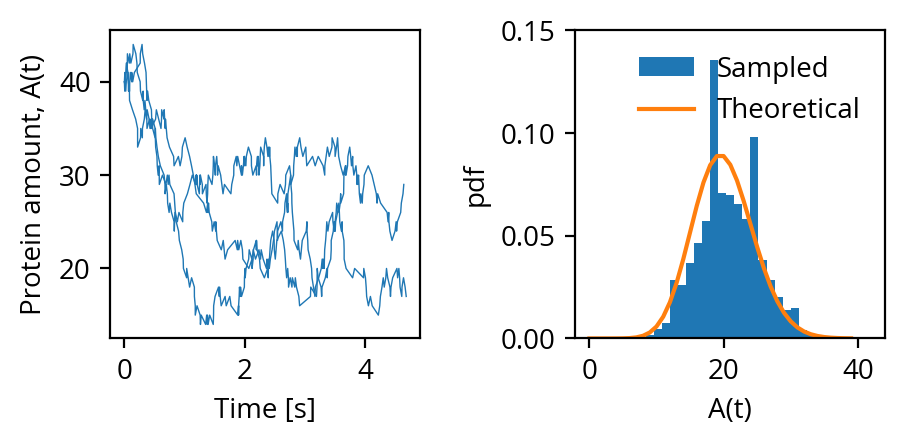

In [11]:
delta_t = 5e-3
n_steps = 600
n_trials = 3

k1 = 1
k2 = 20


fig, axs = plt.subplots(1,2,figsize=(5,2), dpi=200)
fig.subplots_adjust(wspace=0.5)


ax = axs[0]
for _ in range(n_trials):
    As = [40,]
    ts = [0,]
    
    while (ts[-1] < n_steps):

        alpha_0 = k1*As[-1] + k2

        t = rng.exponential(scale=1/alpha_0)
        r = rng.uniform()

        new_A = As[-1]+1 if r < k2/alpha_0 else As[-1]-1
        As.append(new_A)
        ts.append(ts[-1]+t)

    axs[0].plot(ts[:200], As[:200], c='tab:blue', alpha=1, linewidth=0.5)

ax.set_xlabel(r'Time [s]')
ax.set_ylabel('Protein amount, A(t)')


ax = axs[1]
ax.hist(As[50:], bins=30, density=True, label='Sampled');
ax.set_xlabel('A(t)')
ax.set_ylabel('pdf')

X = np.arange(40)
ax.plot(X, stationary_distribution(k1, k2, X), label='Theoretical')

ax.set_ylim(0,0.15)
ax.legend(frameon=False)

**Now with more reactions**

$$
A + A \xrightarrow{k_1} C \\ 
A + B \xrightarrow{k_2} D \\ 
\emptyset \xrightarrow{k_3} A \\
\emptyset \xrightarrow{k_4} B
$$

Apparently, we are not really interested in C and D, so we ignore them.

The genius part is that you are always producing only 2 random variables, and using one for time and one to choose the reaction. Maybe it's obvious but I am a bit slow.

In [15]:
from dataclasses import dataclass
from abc import abstractmethod

In [49]:
@dataclass
class IExperiment:
    species: np.ndarray
    reaction_constants: np.ndarray
    rng: np.random._generator.Generator

    @abstractmethod
    def _compute_propensities(self, dt) -> np.ndarray:
        pass

    @abstractmethod
    def _apply_reaction(self, reaction_index: int):
        pass

    def step_reaction(self, dt) -> np.ndarray:

        propensities = self._compute_propensities(dt)

        # When reaction happens
        alpha_0 = propensities.sum()
        time_to_reaction = rng.exponential(1/alpha_0)

        # Which reaction happens
        reaction_index = rng.multinomial(1, propensities/alpha_0).argmax()

        self._apply_reaction(reaction_index)

        return self.species.copy(), time_to_reaction



In [ ]:
class TwoSpeciesExperiment(IExperiment):
    
    def _compute_propensities(self, dt) -> np.ndarray:
        return np.array([
            dt * self.reaction_constants[0] * self.species[0] * (self.species[0] - 1),
            dt * self.reaction_constants[1] * self.species[0] * self.species[1],
            dt * self.reaction_constants[2],
            dt * self.reaction_constants[3],
        ])

    def _apply_reaction(self, reaction_index):
        match reaction_index:
            case 0:
                self.species[0] -= 2

            case 1:
                self.species[0] -= 1
                self.species[1] -= 1

            case 2:
                self.species[0] += 1
                
            case 3:
                self.species[1] += 1

Text(0, 0.5, 'pdf')

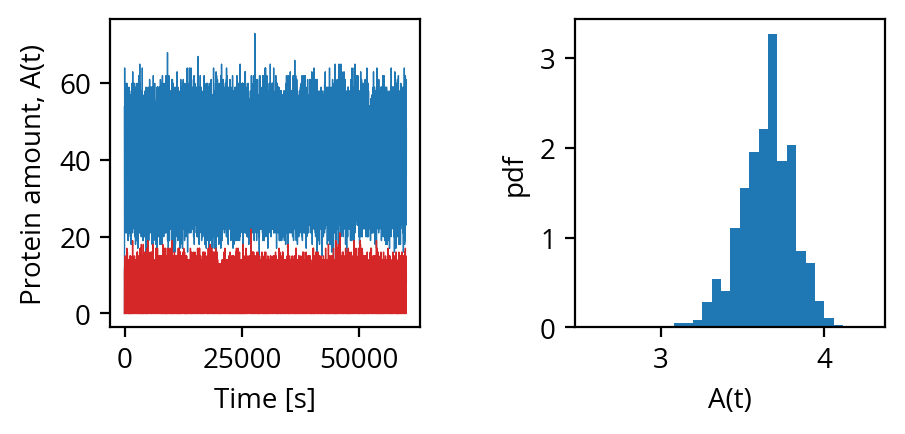

In [139]:
dt = 1e-3
n_steps = 60000
n_trials = 1
rng = np.random.default_rng(2025)

fig, axs = plt.subplots(1,2,figsize=(5,2), dpi=200)
fig.subplots_adjust(wspace=0.5)


ax = axs[0]

for _ in range(n_trials):
    
    experiment = TwoSpeciesExperiment(
        rng=rng,
        species=[0.,0.,],
        reaction_constants = (0.001,0.01,5.,2.,),
    )

    species = [experiment.species.copy(), ]
    ts = [0,]

    while (ts[-1] < n_steps):
        curr_species, time_to_reaction = experiment.step_reaction(dt)
        species.append(curr_species)
        ts.append(ts[-1]+t)

    species = np.stack(species, axis=0)

    axs[0].plot(ts, species.T[0], c='tab:blue', alpha=1, linewidth=0.5)
    axs[0].plot(ts, species.T[1], c='tab:red', alpha=1, linewidth=0.5)

ax.set_xlabel(r'Time [s]')
ax.set_ylabel('Protein amount, A(t)')


ax = axs[1]
ax.hist(np.log(species.T[0, 100:]), bins=30, density=True, label='Sampled');
ax.set_xlabel('A(t)')
ax.set_ylabel('pdf')

# ax.set_ylim(0,0.15)



In [175]:
np.arange(10)[-1:1:-1]

array([9, 8, 7, 6, 5, 4, 3, 2])

In [180]:
class DiffusionExperiment(IExperiment):
    
    def _compute_propensities(self, dt) -> np.ndarray:
        
        right_propensities = np.array([dt * self.reaction_constants * spec for spec in self.species[:-1]])
        left_propensities = np.array([dt * self.reaction_constants * spec for spec in self.species[-1:0:-1]])

        res = np.concatenate((left_propensities, right_propensities))
        print(res.shape, self.species.shape)

        return np.concatenate((left_propensities, right_propensities))


    def _apply_reaction(self, reaction_index):

        left_or_right = -1 if (reaction_index >= len(self.species)-1) else 1

        idx_left_of_pair = reaction_index % (len(self.species)-1)

        self.species[idx_left_of_pair] -= left_or_right
        self.species[idx_left_of_pair-left_or_right] -= left_or_right

In [181]:
dt = 1e-5
n_steps = 110
n_trials = 3


for _ in range(n_trials):
    
    experiment = DiffusionExperiment(
        rng=rng,
        species=rng.uniform(size=100),
        reaction_constants = 1,
    )

    species = [experiment.species.copy(), ]

    while (ts[-1] < n_steps):
        curr_species, _ = experiment.step_reaction(dt)
        species.append(curr_species)

    species = np.stack(species, axis=0)



fig, axs = plt.subplots(1,2,figsize=(5,2), dpi=200)
fig.subplots_adjust(wspace=0.5)

ax = axs[0]
ax.plot(species[0])
ax.set_xlabel(r'Time [s]')
ax.set_ylabel('Protein amount, A(t)')


ax = axs[1]
ax.plot(species[-1])
ax.set_xlabel('A(t)')
ax.set_ylabel('pdf')



(198,) (100,)
(198,) (100,)


ValueError: pvals < 0, pvals > 1 or pvals contains NaNs